NOTE: this should eventually be converted to a Python script once the discrimination model is finalised

NOTE: this was run on a p2.xlarge AWS instance (10-100x speed up because of GPU)

In [1]:
import numpy as np
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from os.path import join as pj   
model = VGG16(weights='imagenet', include_top = False)

Using TensorFlow backend.


In [2]:
#DON"T FORGET that the data dir should have sub dirs of classes
#nb_images must be =< actual number of images or else you get an error (at the end of long processing!)
data_dir = '../data/interim/170329/images/garmin/crop'
nb_images = 76 #garmin
#data_dir = '../data/interim/170329/images/canon/crop'
#nb_images = 40 #canon
batch_size = 1
#batch_size = 100

In [3]:
#move images into a "class" directory as required by ImageDataGenerator
import os
from os.path import join as pj
import shutil
class_dir = pj(data_dir, "unknown")
files = [f for f in os.listdir(data_dir) if f.endswith("jpg")]
if not os.path.exists(class_dir):                                            
    os.makedirs(class_dir)  
    for f in files:
        shutil.move(pj(data_dir, f), pj(class_dir, f))

In [4]:
default_size=224
datagen = ImageDataGenerator(rescale=1., featurewise_center=True)
datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)

generator = datagen.flow_from_directory(
            data_dir,
            classes=["unknown"],
            target_size=(default_size, default_size),
            batch_size=batch_size,
            class_mode=None,
            shuffle=False)
num_batches = nb_images/batch_size
%time bottleneck_features = model.predict_generator(generator, num_batches)
tmp_dir = "../data/tmp"
tmp_path = pj(tmp_dir, 'bottleneck_features.npy')
np.save(open(tmp_path, 'w'), bottleneck_features, allow_pickle=False)

Found 76 images belonging to 1 classes.
CPU times: user 3min 26s, sys: 6.46 s, total: 3min 32s
Wall time: 1min 8s


# Run NN features through a SVM (linear)

In [5]:
tmp_dir = "../data/tmp"
tmp_path = pj(tmp_dir, 'bottleneck_features.npy')
bottleneck_features = np.load(open(tmp_path))

In [6]:
bottleneck_features.shape

(76, 7, 7, 512)

In [7]:
#reshape data
X = bottleneck_features.reshape(nb_images, 7*7*512)

In [9]:
#load model
import pickle
clf = pickle.load(open("../models/vgg_svm_lin_model/vgg_svm_lin_model.p"))

In [10]:
y = clf.predict(X)

In [11]:
score = clf.decision_function(X)

In [12]:
score

array([-0.18878275, -0.01638895, -0.2215439 , -0.05174605, -0.25888382,
       -0.0514407 , -0.36109196, -0.10111677, -0.39238051, -0.12523005,
       -0.04435265, -0.44470538,  0.08052379, -0.49826671,  0.12820101,
       -0.11487228,  0.03833994, -0.05376701, -0.03099927,  0.03287916,
        0.50378518, -0.28691202,  0.53113535, -0.10710696,  0.44323317,
       -0.16590565,  0.20078348,  0.16858158, -0.35238513, -0.44678246,
        1.20695419,  0.69988589, -0.01394982, -0.35013168, -0.27757975,
       -0.19329933, -0.24468809,  1.11151376, -0.12795994,  1.27218108,
       -0.59376648, -0.60940966, -0.25183476, -0.37312434, -0.19778461,
       -0.27051726, -0.21528879, -0.27959809,  0.0814987 , -0.70327773,
       -0.56107993, -0.38170399, -0.41513404, -0.40265439, -0.56479501,
        0.06295714, -0.21924593, -0.02991006, -0.16397379, -0.16995694,
       -0.24669647, -0.26719265,  0.04300186, -0.21216889, -0.26194828,
       -0.19592002, -0.23979597, -0.09248109, -0.26741892, -0.00

In [13]:
np.bincount(y)

array([55, 21])

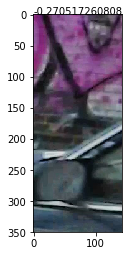

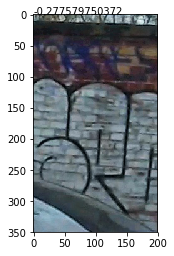

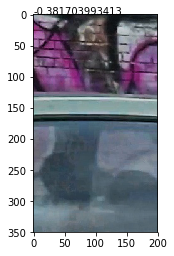

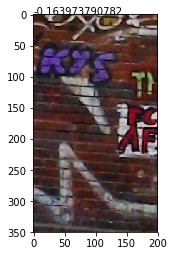

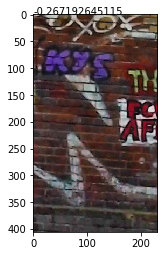

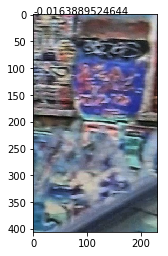

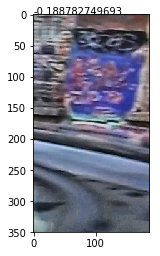

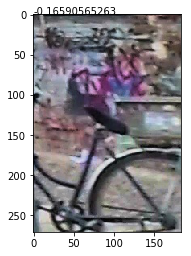

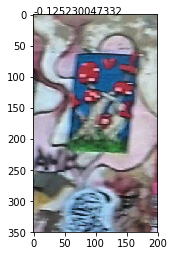

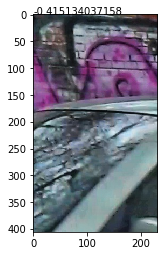

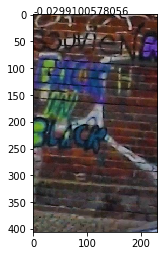

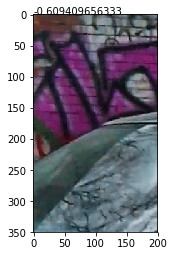

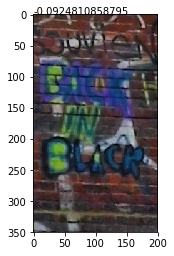

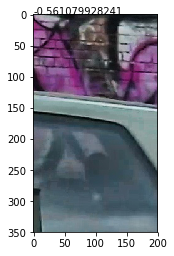

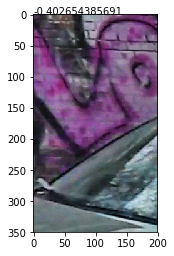

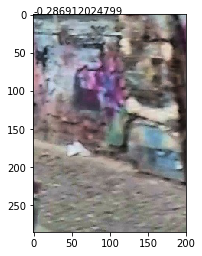

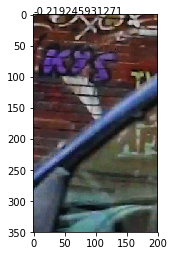

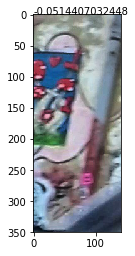

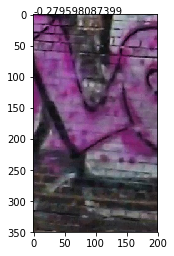

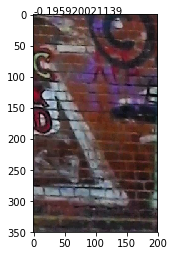

In [21]:
# plot some images classified as not signs
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os.path import join as pj
import random
%matplotlib inline

n_to_draw = 20
n_drawn = 0
zips = [(i, f, s) for i, f, s in zip(y, generator.filenames, score) if i==0]
for i, f, s in random.sample(zips, n_to_draw):
    fig = plt.figure()
    plt.imshow(mpimg.imread(pj(data_dir, f)))
    plt.text(0,0,str(s))
    n_drawn += 1
    if n_drawn >= n_to_draw:
        break            

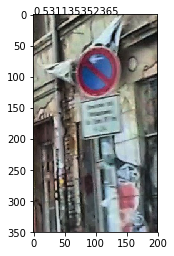

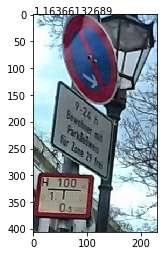

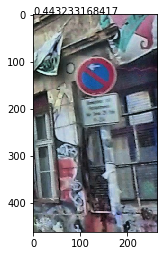

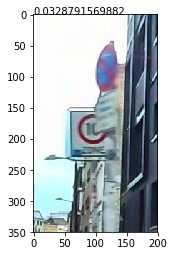

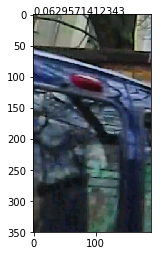

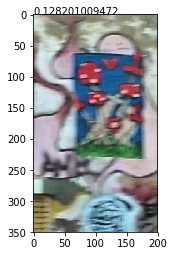

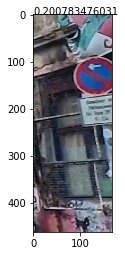

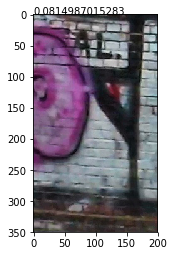

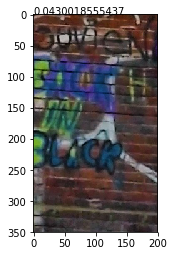

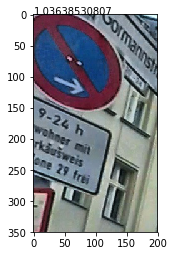

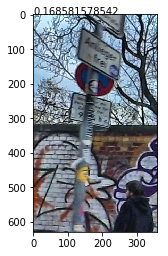

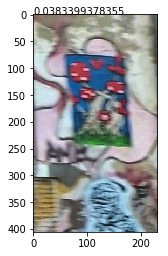

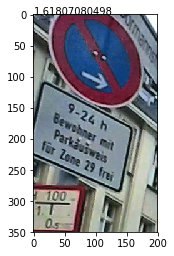

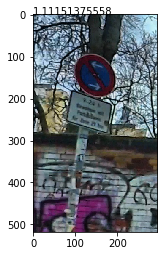

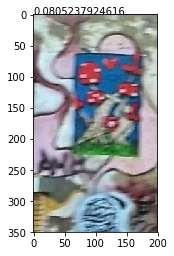

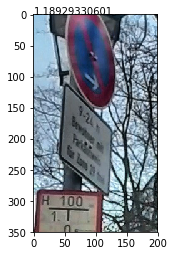

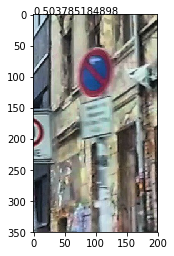

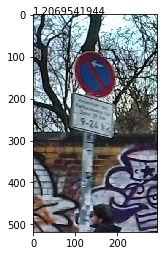

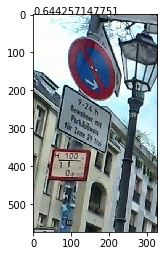

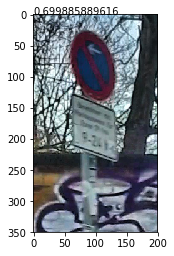

In [20]:
# plot some images classified as signs
n_to_draw = 20
n_drawn = 0
zips = [(i, f, s) for i, f, s in zip(y, generator.filenames, score) if i==1]
for i, f, s in random.sample(zips, n_to_draw):
    fig = plt.figure()
    plt.imshow(mpimg.imread(pj(data_dir, f)))
    plt.text(0,0,str(s))
    n_drawn += 1
    if n_drawn >= n_to_draw:
        break            

# Save predictions as dataframe

In [22]:
import pandas as pd
df = pd.DataFrame({"file":generator.filenames, "y":y, "score":score})
df.head()

,file,score,y
0,unknown/f0019204_x0087_y0609.jpg,-0.188783,0
1,unknown/f0019212_x0479_y0629.jpg,-0.016389,0
2,unknown/f0019216_x0684_y0661.jpg,-0.221544,0
3,unknown/f0019216_x0892_y0874.jpg,-0.051746,0
4,unknown/f0019220_x0899_y0675.jpg,-0.258884,0


In [23]:
df.shape

(76, 3)

In [24]:
df["id"] = df['file'].map(lambda x: x.split('/')[1].split(".")[0])
del df["file"]
df.head()

,score,y,id
0,-0.188783,0,f0019204_x0087_y0609
1,-0.016389,0,f0019212_x0479_y0629
2,-0.221544,0,f0019216_x0684_y0661
3,-0.051746,0,f0019216_x0892_y0874
4,-0.258884,0,f0019220_x0899_y0675


In [25]:
df.to_pickle("../data/tmp/df_id_y_score.pkl")